In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# All of these were stolen from the depths of stackoverflow 
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):

    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def filter_nan_gaussian_david(arr, sigma):
    """Allows intensity to leak into the nan area.
    According to Davids answer:
        https://stackoverflow.com/a/36307291/7128154
    """
    gauss = arr.copy()
    gauss[np.isnan(gauss)] = 0
    gauss = ndimage.gaussian_filter(
            gauss, sigma=sigma, mode='constant', cval=0)

    norm = np.ones(shape=arr.shape)
    norm[np.isnan(arr)] = 0
    norm = ndimage.gaussian_filter(
            norm, sigma=sigma, mode='constant', cval=0)

    # avoid RuntimeWarning: invalid value encountered in true_divide
    norm = np.where(norm==0, 1, norm)
    gauss = gauss/norm
    gauss[np.isnan(arr)] = np.nan
    return gauss

In [3]:
@jit(nopython=True)
def policy(q_vals, beta):
    return np.exp(q_vals*beta)/np.sum(np.exp(q_vals*beta))

def gain(q_vals, exp, beta, alpha, q_true=None):
    
    gain_out = np.empty(exp.shape[0], dtype=np.float64)
    
    for i in range(exp.shape[0]):
        
        q_vals_before = q_vals.copy()
        q_vals_after  = q_vals.copy()
    
        this_exp = exp[i, :]
        
        probs_before = policy(q_vals_before, beta)
        
        a = int(this_exp[0])
        r = this_exp[1]

        delta = r - q_vals_after[a]
        q_vals_after[a] = q_vals_after[a] + alpha*delta

        probs_after = policy(q_vals_after, beta)
        
        if q_true is None:
            EV_pre = np.sum(probs_before*q_vals_after)
            EV_post = np.sum(probs_after*q_vals_after)
        else:
            EV_pre = np.sum(probs_before*q_true)
            EV_post = np.sum(probs_after*q_true)
        
        EV_pre = np.sum(probs_before*q_vals_after)
        EV_post = np.sum(probs_after*q_vals_after)
        
        gain_out[i] = (EV_post - EV_pre)
        
    return gain_out

In [4]:
def run_simulation(R):
    
    T      = np.array([[.5, .5], [.5, .5]])   
    Q      = np.array([0, 0])
    r_hist = np.empty(0)
    av_r   = np.empty(0)
    
    Q_hist = np.zeros(3)
    
    ratio   = np.empty(0)
    
    for t in range(100):
        probs = policy(Q, beta)
        a = np.random.choice([0, 1], p=probs)

        r = R[a]
        delta = r - Q[a]
        Q[a] += alpha*delta

        Q_hist = np.vstack((Q_hist, np.zeros(3)))
        Q_hist[-1, 0] = Q[0]
        Q_hist[-1, 1] = Q[1]
        Q_hist[-1, 2] = 0

        r_hist = np.append(r_hist, r)

        # Update the state transition model
        delta_t  = 1 - T[a, a]
        T[a, a] += alpha_f * delta_t

        # Normalise the transition matrix
        for i in range(2):
            row = T[i, :]
            tmp = np.sum(row)
            T[i, :] = row / tmp

        exp_list = np.empty((2, 2))
        for i in range(2):
            exp_list[i, 0] = i
            exp_list[i, 1] = np.sum(T[i, :]*R)
        
        tmp    = [0, 0]
        while True:
            g = gain(Q.copy(), exp_list, beta, alpha)
            e = g * 1/2

            max_idx = e.argmax()
            if e[max_idx] > evm_thresh:

                was_replay = True
                curr_path = exp_list[max_idx, :]

                ar        = int(curr_path[0])
                rr        = curr_path[1]
                
                tmp[ar] += 1
                
                Q_target = rr

                delta = Q_target - Q[ar]
                Q[ar] = Q[ar] + alpha * delta

            else: break
        
        ratio = np.append(ratio, tmp[1]-tmp[0])
        
    #     if was_replay:
        Q_hist = np.vstack((Q_hist, np.zeros(3)))
        Q_hist[-1, 0] = Q[0]
        Q_hist[-1, 1] = Q[1]
        Q_hist[-1, 2] = 1

        av_rew = np.mean(r_hist)
        av_r = np.append(av_r, av_rew)
        dist   = np.subtract(Q, av_rew)
        Q = Q - (1-tau)*dist

        Q_hist = np.vstack((Q_hist, np.zeros(3)))
        Q_hist[-1, 0] = Q[0]
        Q_hist[-1, 1] = Q[1]
        Q_hist[-1, 2] = 2

        T = rho*T + (1-rho)*.5
        # Normalise the transition matrix
        for i in range(2):
            row = T[i, :]
            tmp = np.sum(row)
            T[i, :] = row / tmp
            
    return Q_hist, np.mean(ratio), av_r

## Figure 4

In [5]:
beta  = 0.9
tau   = 0.8
rho   = 0.90
alpha = 0.2
evm_thresh = 0.00001

alpha_f = 0.98

R = np.array([1, 10])

In [6]:
np.random.seed(21)
Q_hist, rat, av_r = run_simulation(R)
av_rew = np.mean(av_r)

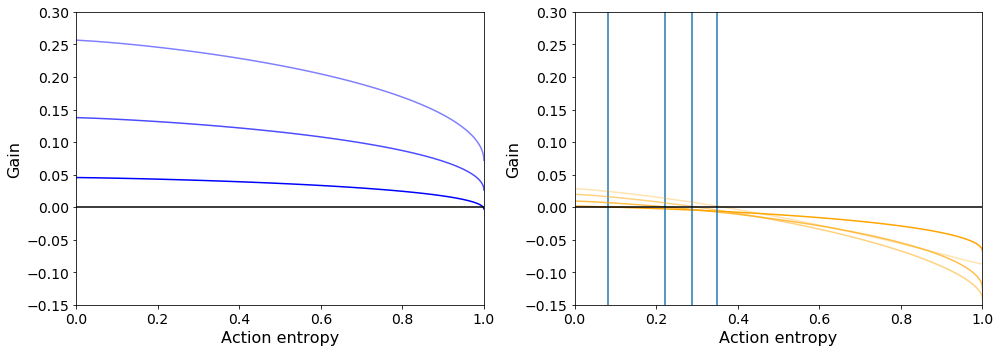

In [17]:
fig = plt.figure(figsize=(14, 5))
tau1 = 0.7
tau2 = 0.5
tau3 = 0.3
tau4 = 0.1
T = np.zeros((2, 2))

c = 0
    
these_gains = np.empty((100, 12))
H = []

Q_old = Q_hist[-3, :2].copy()

vals = np.linspace(0, 0.5, 100)
for i in range(len(vals)):

    val = vals[i]

    T[0, 0] = 1-val
    T[0, 1] = val

    T[1, 0] = val
    T[1, 1] = 1-val

    tmp = 0
    for j in range(2):
        if T[1, j] != 0:
            tmp -= T[1, j]*np.log2(T[1, j])
    H.append(tmp)

    exp = np.empty((2, 2))
    for j in range(2):
        exp[j, 0] = j
        exp[j, 1] = np.sum(T[j, :]*R)

    this_gain = gain(Q_old.copy(), exp, beta, alpha)

    these_gains[i, 0] = this_gain[0]
    these_gains[i, 1] = this_gain[1]

    dist   = np.subtract(Q_old.copy(), av_rew)
    Q_new = Q_old.copy() - (1-tau1)*dist

    this_gain = gain(Q_new, exp, beta, alpha)

    these_gains[i, 2] = this_gain[0]
    these_gains[i, 3] = this_gain[1]

    dist   = np.subtract(Q_old.copy(), av_rew)
    Q_new = Q_old.copy() - (1-tau2)*dist

    this_gain = gain(Q_new, exp, beta, alpha)

    these_gains[i, 4] = this_gain[0]
    these_gains[i, 5] = this_gain[1]
    
    dist   = np.subtract(Q_old.copy(), av_rew)
    Q_new = Q_old.copy() - (1-tau3)*dist

    this_gain = gain(Q_new, exp, beta, alpha)

    these_gains[i, 6] = this_gain[0]
    these_gains[i, 7] = this_gain[1]
    
    dist   = np.subtract(Q_old.copy(), av_rew)
    Q_new = Q_old.copy() - (1-tau4)*dist

    this_gain = gain(Q_new, exp, beta, alpha)

    these_gains[i, 8] = this_gain[0]
    these_gains[i, 9] = this_gain[1]

plt.subplot(1, 2, 1)
alphas = [1, 0.7, 0.5]
c = 0
for i in [0, 2, 4]:
    plt.plot(H, these_gains[:, i], c='b', alpha=alphas[c])
    c += 1
plt.axhline(0, linestyle='-', c='k')
plt.ylim([-0.15, 0.30])
plt.xlim(0, 1)
plt.ylabel('Gain', fontsize=16)
plt.xlabel('Action entropy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
alphas = [1, 0.7, 0.5, 0.3]
c = 0
for i in [1, 3, 5, 7]:
    plt.plot(H, these_gains[:, i], c='orange', alpha=alphas[c])
    plt.axvline(H[np.argwhere(these_gains[:, i] > 0).flatten()[-1]])
    c += 1
# plt.axhline(0.01)
plt.ylabel('Gain', fontsize=16)
plt.xlabel('Action entropy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(0, linestyle='-', c='k')
plt.ylim([-0.15, 0.30])
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure4/gain_MF_many.svg', transparent=True, format='svg')

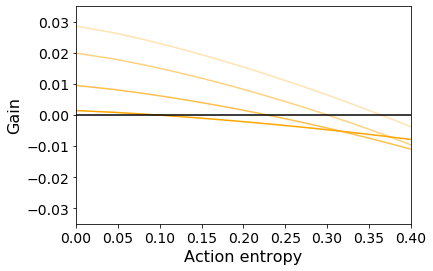

In [23]:
alphas = [1, 0.7, 0.5, 0.3]
c = 0
for i in [1, 3, 5, 7]:
    plt.plot(H, these_gains[:, i], c='orange', alpha=alphas[c])
#     plt.axvline(H[np.argwhere(these_gains[:, i] > 0).flatten()[-1]])
    c += 1
# plt.axhline(0.01)
plt.ylabel('Gain', fontsize=16)
plt.xlabel('Action entropy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(0, linestyle='-', c='k')
plt.ylim([-0.035, 0.035])
plt.xlim(0, 0.4)
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure4/gain_MF_many_inset.svg', transparent=True, format='svg')

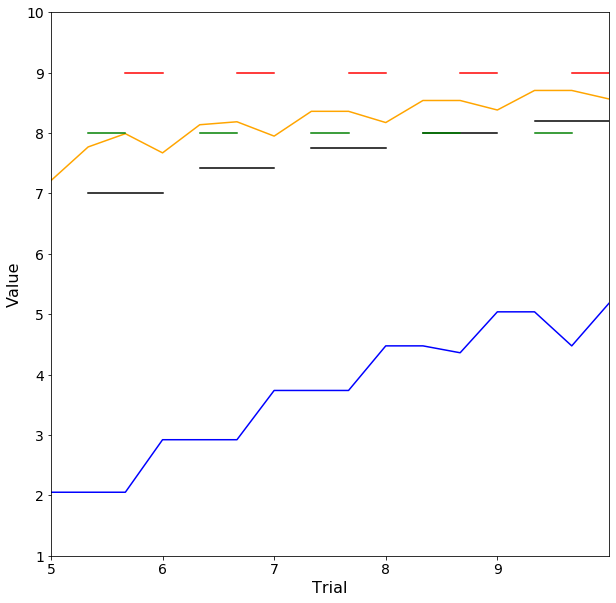

In [8]:
plt.figure(figsize=(10, 10))

plt.plot(Q_hist[12:28, 0], c='b')
plt.plot(Q_hist[12:28, 1], c='orange')

c = 0
for i in range(3, 16, 3):
    plt.plot([i-2, i], [av_r[int((i+12)/3)], av_r[int((i+12)/3)]], c='k')
    c += 1
    
for i in range(3, 16, 3):
    plt.plot([i-1, i], [9, 9], c='r')
    
for i in range(3, 16, 3):
    plt.plot([i-2, i-1], [8, 8], c='green')
    
plt.xticks(range(0, 13, 3), range(5, 10, 1), fontsize=14);
plt.yticks(fontsize=14)

plt.xlabel('Trial', fontsize=16)
plt.ylabel('Value', fontsize=16)

plt.xlim([0, 15]);
plt.ylim([1, 10]);

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure2/Fig2_MF_forget.svg', transparent=True, format='svg')

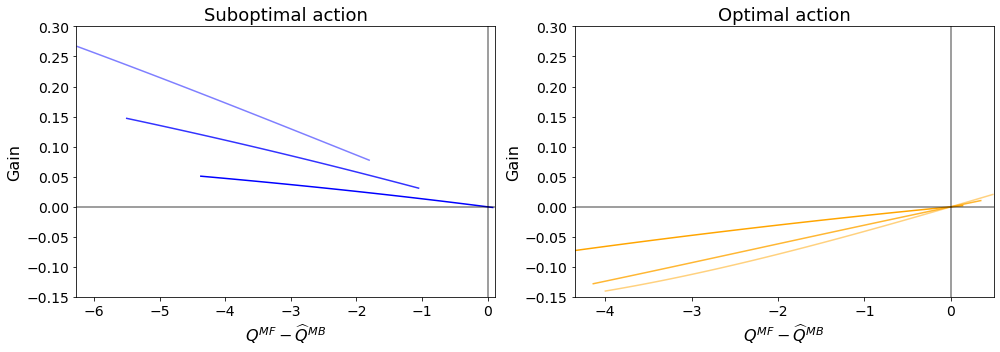

In [89]:
fig = plt.figure(figsize=(14, 5))

T = np.zeros((2, 2))

these_gains = np.empty((700, 6))
these_TDs   = np.empty((700, 6))

Q_old = Q_hist[-1, :2].copy()

dist   = np.subtract(Q_old.copy(), av_rew)
Q1     = Q_old.copy() - (1-tau1)*dist
Q2     = Q_old.copy() - (1-tau2)*dist

vals = np.linspace(-12, 16, 700)
for i in range(len(vals)):

    exp = np.empty((2, 2))
    for j in range(2):
        exp[j, 0] = j
        exp[j, 1] = vals[i]
    
    this_gain = gain(Q_old.copy(), exp, beta, alpha)

    these_gains[i, 0] = this_gain[0]
    these_gains[i, 1] = this_gain[1]

    these_TDs[i, 0] = exp[0, 1] - Q_old[0]
    these_TDs[i, 1] = exp[1, 1] - Q_old[1]

    this_gain = gain(Q1.copy(), exp, beta, alpha)

    these_gains[i, 2] = this_gain[0]
    these_gains[i, 3] = this_gain[1]

    these_TDs[i, 2] = exp[0, 1] - Q1[0]
    these_TDs[i, 3] = exp[1, 1] - Q1[1]

    this_gain = gain(Q2.copy(), exp, beta, alpha)

    these_gains[i, 4] = this_gain[0]
    these_gains[i, 5] = this_gain[1]

    these_TDs[i, 4] = exp[0, 1] - Q2[0]
    these_TDs[i, 5] = exp[1, 1] - Q2[1]

plt.subplot(1, 2, 1)
plt.title('Suboptimal action', fontsize=18)
idcs0 = np.argwhere((these_TDs[:, 0] >= (1-Q_old[0])) & (these_TDs[:, 0] <= (11/2-Q_old[0]))).flatten()
plt.plot(these_TDs[idcs0, 0], these_gains[idcs0, 0], c='b', alpha=1)

idcs2 = np.argwhere((these_TDs[:, 2] >= (1-Q1[0])) & (these_TDs[:, 2] <= (11/2-Q1[0]))).flatten()
plt.plot(these_TDs[idcs2, 2], these_gains[idcs2, 2], c='b', alpha=0.8)

idcs4 = np.argwhere((these_TDs[:, 4] >= (1-Q2[0])) & (these_TDs[:, 4] <= (11/2-Q2[0]))).flatten()
plt.plot(these_TDs[idcs4, 4], these_gains[idcs4, 4], c='b', alpha=0.5)

plt.ylabel('Gain', fontsize=16)
plt.xlabel(r'$Q^{MF}-\widehat{Q}^{MB}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1-Q2.min(), 11/2-Q_old.min())
plt.ylim(-0.15, 0.3)
plt.axhline(0, linestyle='-', c='k', alpha=0.5)
plt.axvline(0, linestyle='-', c='k', alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Optimal action', fontsize=18)
idcs1 = np.argwhere((these_TDs[:, 1] >= (11/2-Q_old[1])) & (these_TDs[:, 1] <= (10-Q_old[1]))).flatten()
plt.plot(these_TDs[idcs1, 1], these_gains[idcs1, 1], c='orange', alpha=1)

idcs3 = np.argwhere((these_TDs[:, 3] >= (11/2-Q1[1])) & (these_TDs[:, 3] <= (10-Q1[1]))).flatten()
plt.plot(these_TDs[idcs3, 3], these_gains[idcs3, 3], c='orange', alpha=0.8)

idcs5 = np.argwhere((these_TDs[:, 5] >= (11/2-Q2[1])) & (these_TDs[:, 5] <= (10-Q2[1]))).flatten()
plt.plot(these_TDs[idcs5, 5], these_gains[idcs5, 5], c='orange', alpha=0.5)

plt.ylabel('Gain', fontsize=16)
plt.xlabel(r'$Q^{MF}-\widehat{Q}^{MB}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(11/2-Q_old.max(), 10-Q2.max())
plt.ylim(-0.15, 0.3)
plt.axhline(0, linestyle='-', c='k', alpha=0.5)
plt.axvline(0, linestyle='-', c='k', alpha=0.5)

plt.tight_layout()
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure3/gain_TD.svg', format='svg', transparent=True)

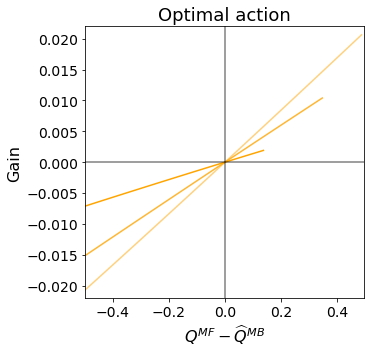

In [90]:
fig = plt.figure(figsize=(5, 5))

plt.title('Optimal action', fontsize=18)
plt.plot(these_TDs[idcs1, 1], these_gains[idcs1, 1], c='orange', alpha=1)
plt.plot(these_TDs[idcs3, 3], these_gains[idcs3, 3], c='orange', alpha=0.8)
plt.plot(these_TDs[idcs5, 5], these_gains[idcs5, 5], c='orange', alpha=0.5)

plt.ylabel('Gain', fontsize=16)
plt.xlabel(r'$Q^{MF}-\widehat{Q}^{MB}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-0.5, 10-Q2.max())
plt.ylim(-0.022, 0.022)
plt.axhline(0, linestyle='-', c='k', alpha=0.5)
plt.axvline(0, linestyle='-', c='k', alpha=0.5)
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure3/gain_TD_inset.svg', format='svg', transparent=True)

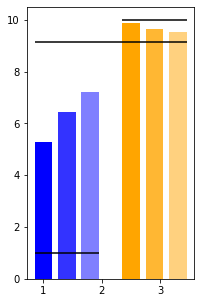

In [88]:
plt.figure(figsize=(3, 5))

plt.bar(1, Q_old[0], facecolor='b',width=0.3, align='center')
plt.bar(2.5, Q_old[1], facecolor='orange', width=0.3, align='center')

plt.bar(1.4, Q1[0], facecolor='b',width=0.3, align='center',alpha=0.8)
plt.bar(2.9, Q1[1], facecolor='orange', width=0.3, align='center',alpha=0.8)

plt.bar(1.8, Q2[0], facecolor='b',width=0.3, align='center',alpha=0.5)
plt.bar(3.3, Q2[1], facecolor='orange', width=0.3, align='center',alpha=0.5)

plt.hlines(1, 1-0.15, 1.8+0.15)
plt.hlines(10, 2.5-0.15, 3.3+0.15)

plt.hlines(av_rew, 1-0.15, 3.3+0.15)

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure3/gain_TD_Q.svg', format='svg', transparent=True)

## Supplementary

In [793]:
r1 = np.arange(0, 10.1, 0.1)
r2 = np.arange(0, 10.1, 0.1)

num    = len(r1)
reps   = 20

all_ranges = np.zeros((num, num, reps))
all_ratios = np.zeros((num, num, reps))

for rep in range(reps):

    ranges = np.zeros((num, num))
    ratios = np.zeros((num, num))
    
    for r1i in range(len(r1)):
        this_r1 = r1[r1i]
        for r2i in range(len(r2)):
            this_r2 = r2[r2i]
            if r1i > r2i:
                ranges[r1i, r2i] = np.nan
                ratios[r1i, r2i] = np.nan
                continue
            
            R = [this_r1, this_r2]
            
            Q_hist, ratio, _ = run_simulation(R)

            T = np.zeros((2, 2))
            these_gains = np.empty((100, 2))
            H = []

            vals = np.linspace(0, 0.5, 100)
            for i in range(len(vals)):

                Q_old = Q_hist[-1, :2].copy()

                val = vals[i]

                T[0, 0] = 1-val
                T[0, 1] = val

                T[1, 0] = val
                T[1, 1] = 1-val

                tmp = 0
                for j in range(2):
                    if T[1, j] != 0:
                        tmp -= T[1, j]*np.log2(T[1, j])
                H.append(tmp)

                exp = np.empty((2, 2))
                for j in range(2):
                    exp[j, 0] = j
                    exp[j, 1] = np.sum(T[j, :]*R)

                this_gain = gain(Q_old, exp, beta, alpha)

                these_gains[i, 0] = this_gain[0]
                these_gains[i, 1] = this_gain[1]

            subopt = np.argwhere(these_gains[:,0] > 0).flatten()
            opt    = np.argwhere(these_gains[:,1] > 0).flatten()

            if len(subopt) == 0 or len(opt) == 0:
                ranges[r1i, r2i] = np.nan
            else:
                ranges[r1i, r2i] = H[subopt[-1]]-H[opt[-1]]

            ratios[r1i, r2i] = ratio
                
    all_ranges[:, :, rep] = ranges
    all_ratios[:, :, rep] = ratios
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/GA/miniconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


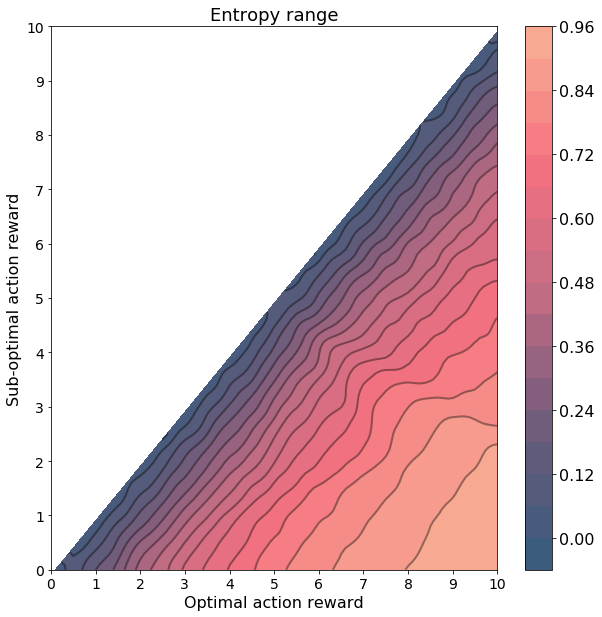

In [811]:
tmp = np.nanmean(all_ranges, axis=2)
tmp = filter_nan_gaussian_david(tmp, 1.5)

for i in range(tmp.shape[0])[::-1]:
    for j in range(tmp.shape[0]):
        if (j-1) < i:
            tmp[i, j] = np.nan

plt.figure(figsize=(10, 10))

hex_list = ['#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D'][::-1]
plt.contourf(tmp, 16, cmap=get_continuous_cmap(hex_list))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.contour(tmp, 16, colors=['k']*1, linewidths=2, alpha=0.4)
plt.xticks(range(0, 101, 10), range(0, 11, 1), fontsize=14);
plt.yticks(range(0, 101, 10), range(0, 11, 1), fontsize=14);
plt.xlabel('Optimal action reward', fontsize=16);
plt.ylabel('Sub-optimal action reward', fontsize=16);
plt.title('Entropy range', fontsize=18)

np.save('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp6/entropy_range.npy', tmp)
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp6/entropy_range.svg', format='svg', transparent=True)

/Users/GA/miniconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


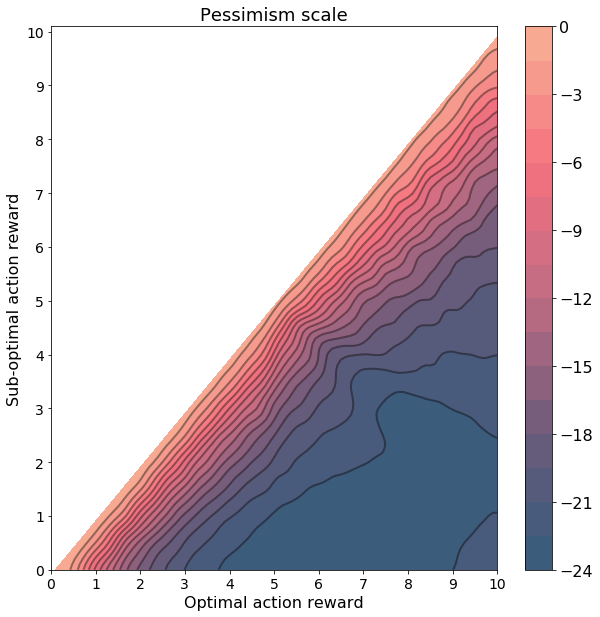

In [812]:
tmp = np.nanmean(all_ratios, axis=2)
tmp = filter_nan_gaussian_david(tmp, 1.5)

for i in range(tmp.shape[0])[::-1]:
    for j in range(tmp.shape[0]):
        if (j-1) < i:
            tmp[i, j] = np.nan
            
plt.figure(figsize=(10, 10))

hex_list = ['#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D'][::-1]
plt.contourf(tmp, 16, cmap=get_continuous_cmap(hex_list))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.contour(tmp, 16, colors=['k']*1, linewidths=2, linestyles='solid', alpha=0.4)
plt.ylim(0, num)
plt.xticks(range(0, 101, 10), range(0, 11, 1), fontsize=14);
plt.yticks(range(0, 101, 10), range(0, 11, 1), fontsize=14);
plt.xlabel('Optimal action reward', fontsize=16);
plt.ylabel('Sub-optimal action reward', fontsize=16);
plt.title('Pessimism scale', fontsize=18)

np.save('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp6/pessimism_scale.npy', tmp)
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp6/pessimism_scale.svg', format='svg', transparent=True)